# A simple profiler

This is the first cut at a simple time-spent profiler for nodes. 

The code to profile is just the previously defined FRED code.

Although primitive, the profiler output does show a few things:
1. The bulk of the time is spent in fetching data pages.
2. The ExternalRefData.state method is a mess:
 * It should load data pages lazily, not deeply in the EncDec mechanics
 * The low-level ObjMeta/dataField code hides some stuff we would like to expose at the node level
3. Wow, this code is quite slow. Especially when my laptop is overheating:
 * We'll fix the slowness later

In [1]:
import mand.core

from mand.core import Entity, node, Context, _tr, ObjectDb, _DBO, EncDec
from mand.core import displayDict, displayListOfDicts
from mand.core import Monitor, PrintMonitor, SummaryMonitor
from mand.lib.extrefdata import ExternalRefData, dataField

from mand.user.refdata.FRED import FredManager, FredSeries, FredCategory

db = ObjectDb(name='production-1', inMem=False, ro=True)

%matplotlib inline


In [2]:
import time

class ProfileMonitor(Monitor):

    def __init__(self, mode=None):
        self.stack = []
        self.result = []
        self.mode = mode
        
    def message(self, sys, depthInc, action, **kw):
        if depthInc == 1:
            v = [kw, time.clock(), 0]
            self.stack.append(v)
            
        if depthInc == -1:
            kw, start, tSub = self.stack.pop()
            t = time.clock() - start
            tFn = t - tSub
            if self.stack:
                self.stack[-1][-1] += t
            
            self.result.append((tFn, t, sys, kw))
             
    def dumpRaw(self):
        for tFn, t, sys, kw in self.result:
            key = self.kwToStr(kw)
            print '%8.4f %8.4f %-16s: %s' % (tFn, t, sys, key)
            
    def displaySum(self):
        n = {}
        cumT = {}
        cumTCalc = {}
        tScale = 1e6
        for tFn, t, sys, kw in self.result:
            if sys == 'Db.Get': # XXX - this should get its own key.
                fn = kw.get('value', '//').split('/')[2]
            else:
                fn = kw.get('key', (None, ''))[1]
            key = (sys, fn)
            cumT[key] = cumT.get(key, 0) + t * tScale
            cumTCalc[key] = cumTCalc.get(key, 0) + tFn * tScale
            n[key] = n.get(key, 0) + 1
        res = []
        for key in n:
            line = { 'n': n[key], 
                     'cumT': int(cumT[key]),
                     'cumT/call': int(cumT[key]/n[key]),
                     'calcT': int(cumTCalc[key]),
                     'sys': key[0],
                     'fn': key[1]}
            res.append(line)
        res = sorted(res, key=lambda d: -d['cumT'])
        print 'Total times are in microseconds'
        print '  cumT is total time spent in funtion'
        print '  calcT is time spent in function, but not in a child node'
        displayListOfDicts(res, names=['fn', 'n', 'cumT', 'calcT', 'cumT/call', 'sys'])
    def onExit(self):
        mode = self.mode
        if mode is None:
            self.dumpRaw()
        elif mode == 'sum':
            self.displaySum()
        else:
            assert False, 'unknown profiler mode: %s' % mode

In [3]:
class Test(_DBO):
    @node
    def info(self):
        fc = FredCategory.get('94', self.meta.db, create=True)
        info = []
        if fc.seriesNames():
            for s in fc.series():
                seriesInfo = s.info()
                info.append(dict([ (k, seriesInfo[k]) for k in ['id', 'title'] ]) )
        return info
        
with ProfileMonitor(mode='sum'):
    with PrintMonitor(include='Web'):
        t = Test('Test', db=db)
        info = t.info()
        
print 'count is:', len(info)
displayListOfDicts(info)

Total times are in microseconds
  cumT is total time spent in funtion
  calcT is time spent in function, but not in a child node


|fn|n|cumT|calcT|cumT/call|sys|
|-|-|-|-|-|-|
|Test:info|1|17678783|33|17678783|GetValue
|Test:info|1|17678749|750|17678749|GetValue/Calc
|ExternalRefData:state|28|17631710|409|629703|GetValue
|ExternalRefData:state|27|17631301|5057|653011|GetValue/Calc
|ExternalDataPage|313|17499635|17499635|55909|Db.Get
|RefData:state|27|126607|247|4689|GetValue
|RefData:state|27|126360|53556|4680|GetValue/Calc
|RefDataUpdateEvent|27|67769|67769|2509|Db.Get
|FredCategory:series|1|42926|13|42926|GetValue
|FredCategory:series|1|42912|441|42912|GetValue/Calc
|FredSeries|26|42466|42466|1633|Db.Get
|FredCategory|1|3366|3366|3366|Db.Get
|RefData:clock|54|2589|457|47|GetValue
|Clock:cutoffs|54|2155|207|39|GetValue
|RefData:clock|27|2132|319|78|GetValue/Calc
|Clock:cutoffs|1|1947|27|1947|GetValue/Calc
|Clock:parent|1|1917|10|1917|GetValue
|Clock:parent|1|1906|1806|1906|GetValue/Calc
|Clock|1|1813|1813|1813|Db.Get
|Event:amends|27|162|162|6|GetValue
|RefDataUpdateEvent:data|27|126|126|4|GetValue
|RootClock:cutoffs|3|70|15|23|GetValue
|RootClock:cutoffs|1|55|25|55|GetValue/Calc
|Entity:clock|2|32|21|16|GetValue
|RootClock:cosmicAll|1|17|9|17|GetValue
|CosmicAll:dbState|1|13|8|13|GetValue
|Entity:clock|1|10|10|10|GetValue/Calc
|RootClock:cosmicAll|1|8|8|8|GetValue/Calc
|CosmicAll:dbState|1|4|4|4|GetValue/Calc

count is: 26


|id|title|
|-|-|
|DEXBZUS|Brazil / U.S. Foreign Exchange Rate
|DEXCAUS|Canada / U.S. Foreign Exchange Rate
|DEXCHUS|China / U.S. Foreign Exchange Rate
|DEXDNUS|Denmark / U.S. Foreign Exchange Rate
|DEXHKUS|Hong Kong / U.S. Foreign Exchange Rate
|DEXINUS|India / U.S. Foreign Exchange Rate
|DEXJPUS|Japan / U.S. Foreign Exchange Rate
|DEXKOUS|South Korea / U.S. Foreign Exchange Rate
|DEXMAUS|Malaysia / U.S. Foreign Exchange Rate
|DEXMXUS|Mexico / U.S. Foreign Exchange Rate
|DEXNOUS|Norway / U.S. Foreign Exchange Rate
|DEXSDUS|Sweden / U.S. Foreign Exchange Rate
|DEXSFUS|South Africa / U.S. Foreign Exchange Rate
|DEXSIUS|Singapore / U.S. Foreign Exchange Rate
|DEXSLUS|Sri Lanka / U.S. Foreign Exchange Rate
|DEXSZUS|Switzerland / U.S. Foreign Exchange Rate
|DEXTAUS|Taiwan / U.S. Foreign Exchange Rate
|DEXTHUS|Thailand / U.S. Foreign Exchange Rate
|DEXUSAL|U.S. / Australia Foreign Exchange Rate
|DEXUSEU|U.S. / Euro Foreign Exchange Rate
|DEXUSNZ|U.S. / New Zealand Foreign Exchange Rate
|DEXUSUK|U.S. / U.K. Foreign Exchange Rate
|DEXVZUS|Venezuela / U.S. Foreign Exchange Rate
|DTWEXB|Trade Weighted U.S. Dollar Index: Broad
|DTWEXM|Trade Weighted U.S. Dollar Index: Major Currencies
|DTWEXO|Trade Weighted U.S. Dollar Index: Other Important Trading...

Swiss Francs to One U.S. Dollar


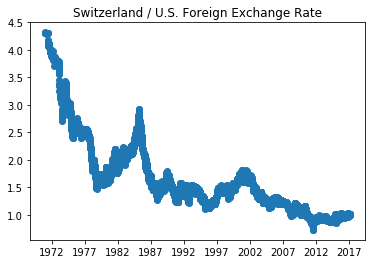

U.S. Dollars to One British Pound


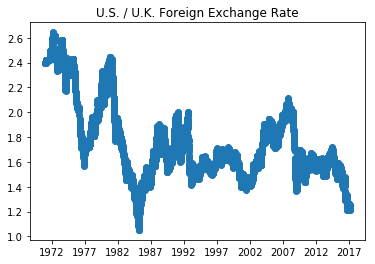

U.S. Dollars to One Euro


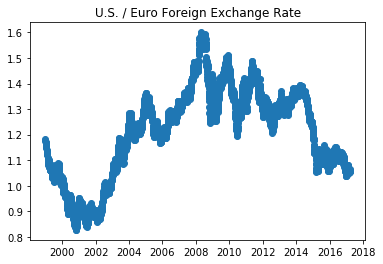

In [4]:
chf = FredSeries.get('DEXSZUS', db, create=True)
print chf.info()['units']
chf.plot()

gbp = FredSeries.get('DEXUSUK', db, create=True)
print gbp.info()['units']
gbp.plot()

eur = FredSeries.get('DEXUSEU', db, create=True)
print eur.info()['units']
eur.plot()